In [13]:
import numpy as np
import os

from type_definitions.test_case import TestCase
from type_definitions.test_result import TestResult
from type_definitions.utils import *
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import OPTICS
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [14]:
seed = 100
save_plot = False
use_cached_distance_matrix = True  # Set to False to force recalculation

In [15]:
np.random.seed(seed)

cases = generate_cases(80)
results = evaluate_cases(cases)
trajectories = [r.trajectory for r in results if not r.simulation_failed]
valid_results = [r for r in results if not r.simulation_failed]

print(f"Generated {len(trajectories)} valid trajectories")
print(
    f"Crashed: {sum(1 for r in valid_results if r.crashed)}, Safe: {sum(1 for r in valid_results if not r.crashed)}"
)
print(trajectories[0][:, 6])


Generated 38 valid trajectories
Crashed: 16, Safe: 22
[ 3.90910205e-01  3.27140203e-01  2.61173878e-01  1.85254425e-01
  1.04349280e-01  2.78627305e-02 -3.58020164e-02 -8.10291422e-02
 -1.05678754e-01 -1.09872443e-01 -9.52603706e-02 -6.40671234e-02
 -1.87108481e-02  2.20555000e-02  4.77600466e-02  6.87332035e-02
  9.09569648e-02  1.12716504e-01  1.31028432e-01  1.44937197e-01
  1.55007088e-01  1.61573844e-01  1.64886499e-01  1.64874938e-01
  1.61716967e-01  1.55673608e-01  1.47185258e-01  1.36719640e-01
  1.24703365e-01  1.11554372e-01  9.77623785e-02  8.37318868e-02
  6.97407605e-02  5.61447377e-02  4.32584717e-02  3.12367278e-02
  2.02782384e-02  1.05366484e-02  2.05391365e-03 -5.10318847e-03
 -1.09066048e-02 -1.54235967e-02 -1.87087546e-02 -2.08021716e-02
 -2.18374547e-02 -2.19470211e-02 -2.12103690e-02 -1.97779410e-02
 -1.78109235e-02 -1.53982670e-02 -1.26741801e-02 -9.77323255e-03
 -6.77612068e-03 -3.78411104e-03 -8.77641156e-04  1.88609244e-03
  4.44800753e-03  6.77445342e-03  8.

In [ ]:
os.makedirs("cache", exist_ok=True)
dim_map = {
    "pos_n": 0,
    "pos_e": 1,
    "alt": 2,
    "phi": 3,
    "theta": 4,
    "psi": 5,
    "g": 6,
}

# File paths for each dimension
n = len(trajectories)
file_map = {
    name: f"cache/distance_matrix_{name}_seed{seed}_size{n}.npy"
    for name in dim_map.keys()
}

# Toggle to use cached matrices if available (set this earlier in the notebook)
# use_cached_distance_matrix = True

# Load or compute-and-save per-dimension distance matrices
if use_cached_distance_matrix and all(os.path.exists(p) for p in file_map.values()):
    print("Loading per-dimension distance matrices from cache...")
    dim_mats = {name: np.load(path) for name, path in file_map.items()}
else:
    print("Calculating per-dimension pairwise distances...")
    dim_mats = {
        name: pairwise_distances([traj[:, [idx]] for traj in trajectories], n_jobs=1)
        for name, idx in dim_map.items()
    }
    for name, D in dim_mats.items():
        np.save(file_map[name], D)
    print("Per-dimension distance matrices saved to cache.")

# Quick summary
for name, D in dim_mats.items():
    print(f"{name} matrix shape: {D.shape}")

Calculating per-dimension pairwise distances...


ValueError: max_workers must be greater than 0

In [ ]:


k_centers = 5  # adjust this value as needed

def cluster_greedy(D, k):
    center_indices, cluster_assignments = greedy_permutation_clustering(D, k)
    return cluster_assignments

clusters_by_dim = {name: cluster_greedy(D, k_centers) for name, D in dim_mats.items()}

for name, labels in clusters_by_dim.items():
    counts = {int(k): int(v) for k, v in zip(*np.unique(labels, return_counts=True))}
    print(f"{name}: {counts}")




pos_n: {0: 15, 1: 3, 2: 4, 3: 9, 4: 7}
pos_e: {0: 12, 1: 4, 2: 2, 3: 10, 4: 10}
alt: {0: 18, 1: 4, 2: 7, 3: 4, 4: 5}
phi: {0: 11, 1: 3, 2: 6, 3: 9, 4: 9}
theta: {0: 24, 1: 3, 2: 2, 3: 3, 4: 6}
psi: {0: 27, 1: 3, 2: 1, 3: 4, 4: 3}
g: {0: 21, 1: 1, 2: 5, 3: 2, 4: 9}


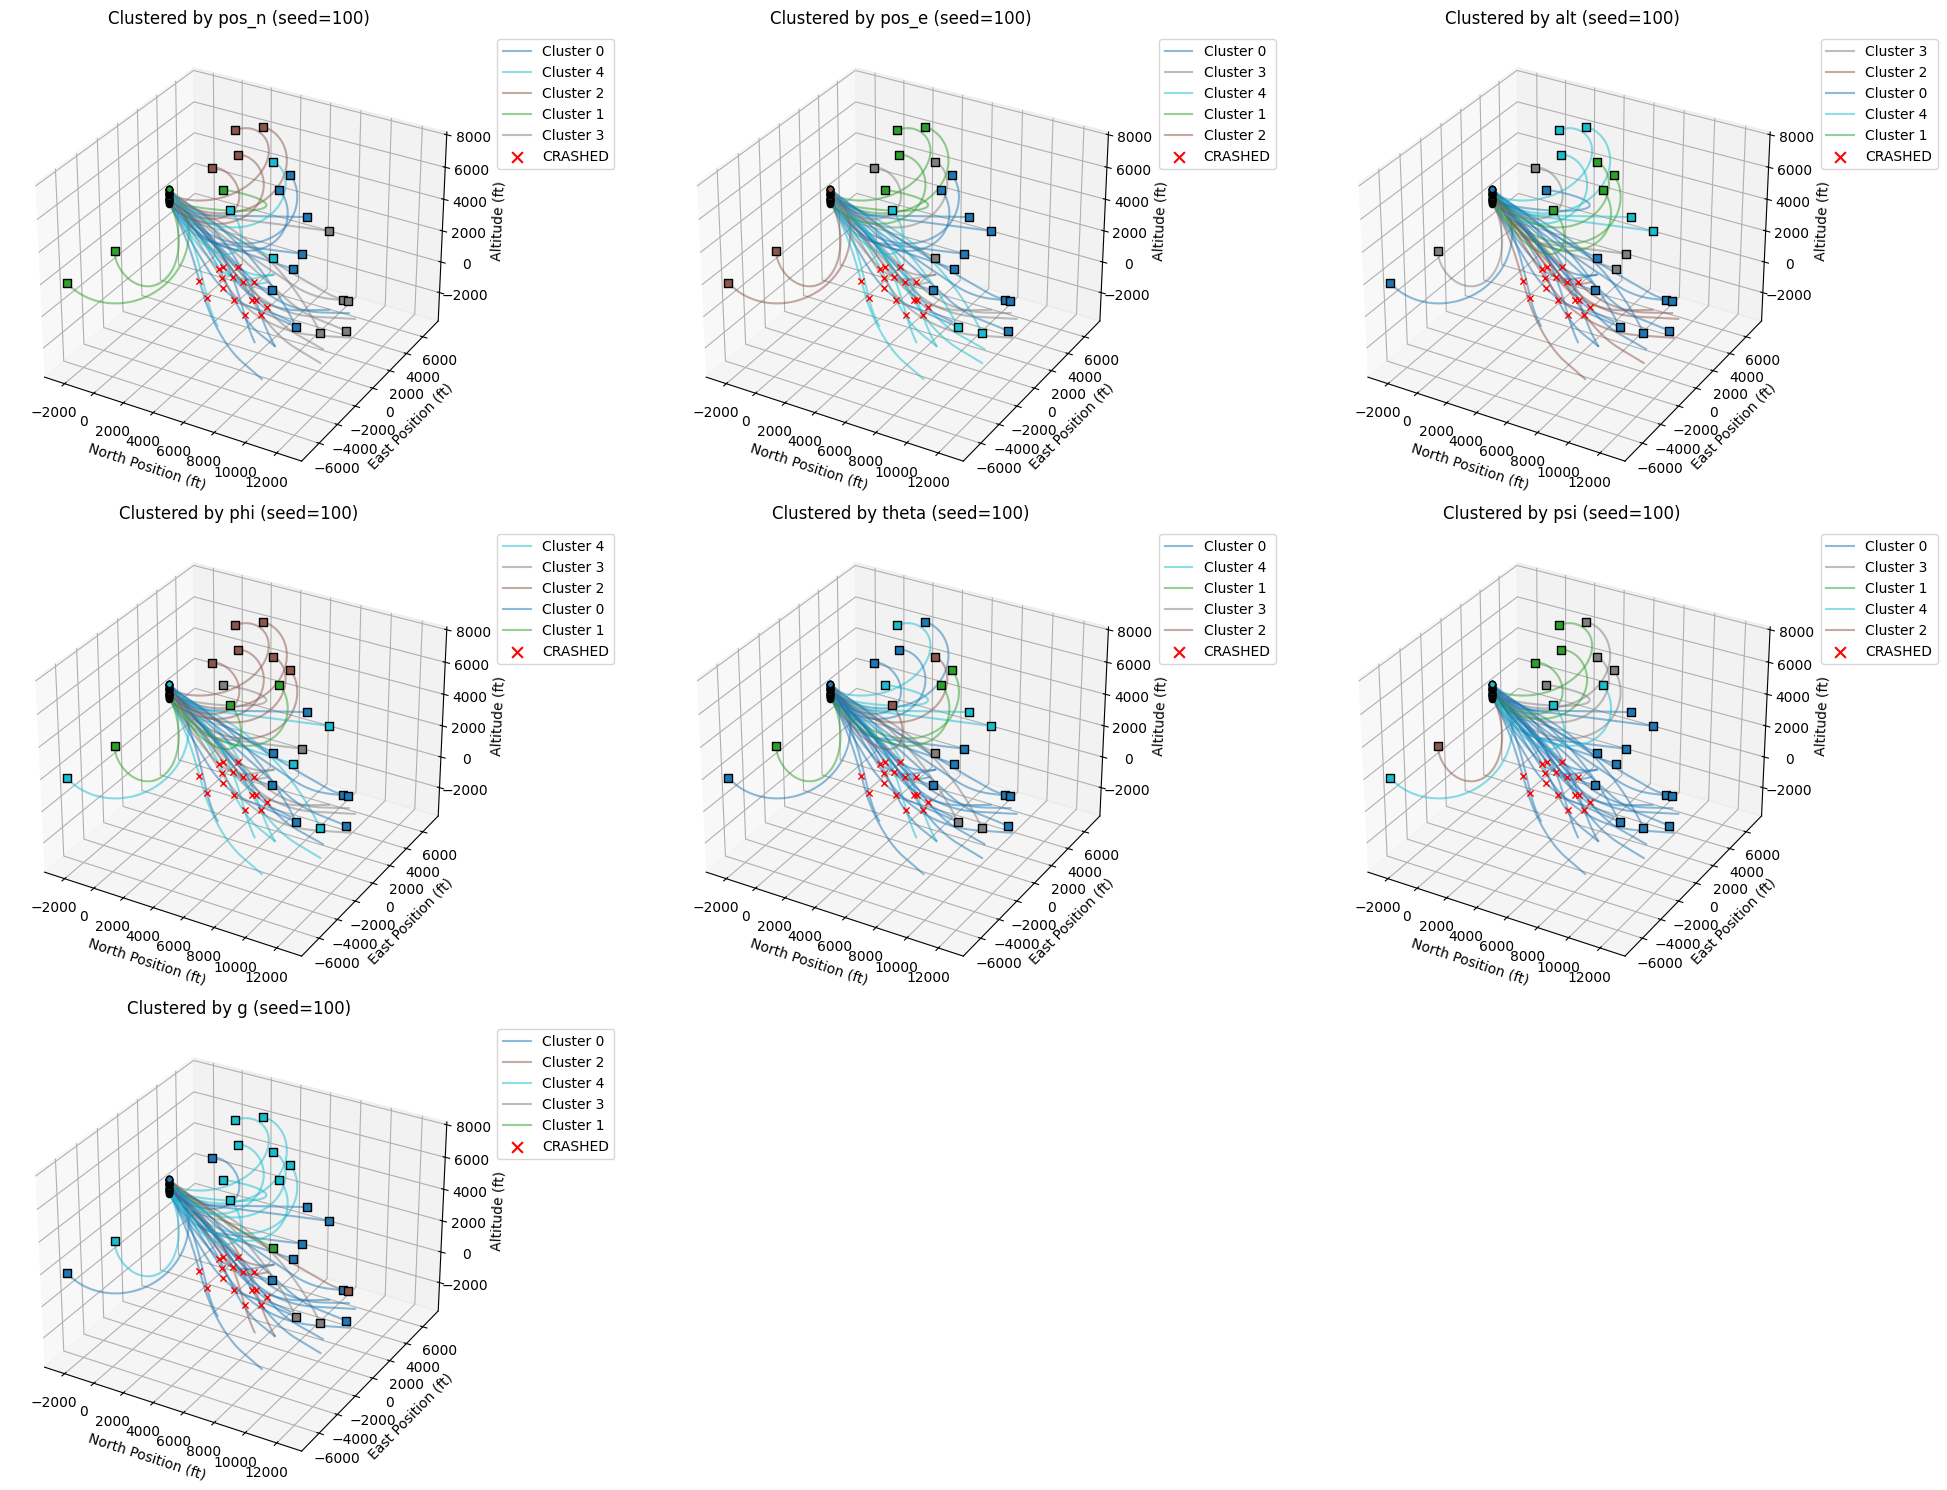

In [ ]:

dimensions_to_plot = list(dim_map.keys())  # ["pos_n", "pos_e", "alt", "phi", "theta", "psi", "g"]

fig = plt.figure(figsize=(20, 15))

for plot_idx, dim_name in enumerate(dimensions_to_plot):
    # Calculate subplot position: 3 rows, 3 columns (with 2 empty spots)
    row = plot_idx // 3
    col = plot_idx % 3
    
    ax = fig.add_subplot(3, 3, plot_idx + 1, projection="3d")
    
    # Get clusters for this dimension
    clusters = clusters_by_dim[dim_name]
    unique_clusters = np.unique(clusters)
    colors = plt.get_cmap("tab10")(np.linspace(0, 1, len(unique_clusters)))
    
    valid_results = [r for r in results if not r.simulation_failed]
    
    plotted_clusters = set()
    plotted_noise = False
    
    for i, (traj, cluster_id, result) in enumerate(
        zip(trajectories, clusters, valid_results)
    ):
        if cluster_id == -1:  # noise points in DBSCAN
            color = "black"
            if not plotted_noise:
                label = "Noise"
                plotted_noise = True
            else:
                label = None
        else:
            color = colors[cluster_id % len(colors)]
            if cluster_id not in plotted_clusters:
                label = f"Cluster {cluster_id}"
                plotted_clusters.add(cluster_id)
            else:
                label = None
        
        ax.plot(
            traj[:, 0],  # North
            traj[:, 1],  # East  
            traj[:, 2],  # Altitude
            color=color,
            alpha=0.5,
            linewidth=1.5,
            linestyle="-",
            label=label,
        )
        
        # Start point
        ax.scatter(
            traj[0, 0],
            traj[0, 1],
            traj[0, 2],
            color=color,
            s=20,
            marker="o",
            edgecolor="black",
            linewidth=1,
        )
        
        # End points
        if result.crashed:
            crash_idx = np.where(traj[:, 2] <= 0)[0]
            if len(crash_idx) > 0:
                crash_idx = crash_idx[0]
                crash_x = traj[crash_idx, 0]
                crash_y = traj[crash_idx, 1]
                crash_z = traj[crash_idx, 2]
            else:
                min_alt_idx = np.argmin(result.trajectory[:, 2])
                crash_x = traj[min_alt_idx, 0]
                crash_y = traj[min_alt_idx, 1]
                crash_z = traj[min_alt_idx, 2]
            
            ax.scatter(
                crash_x,
                crash_y,
                crash_z,
                color="red",
                s=20,
                marker="x",
                linewidth=1,
            )
        else:
            ax.scatter(
                traj[-1, 0],
                traj[-1, 1],
                traj[-1, 2],
                color=color,
                s=30,
                marker="s",
                edgecolor="black",
                linewidth=1,
            )
    
    if any(result.crashed for result in valid_results):
        ax.scatter([], [], color="red", marker="x", s=60, label="CRASHED")
    
    ax.set_xlabel("North Position (ft)")
    ax.set_ylabel("East Position (ft)")
    ax.set_zlabel("Altitude (ft)")
    ax.set_title(f"Clustered by {dim_name} (seed={seed})")
    ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
if save_plot:
    plt.savefig(f"results/{seed}_clusters_all_dimensions.png")
    print(f"Plot saved to results/{seed}_clusters_all_dimensions.png")